In [1]:
import sys
sys.path.append("..")

import tensorflow as tf

from utils import data_utils, preprocess_data, tf_config, train, losses_utils, lrp, viz_utils, fmri_utils

from layers import topographical_attention

from models import classifiers, eeg_to_fmri

memory_limit=1500
interval_eeg=10

tf_config.set_seed(seed=3)#02 20
tf_config.setup_tensorflow(device="GPU", memory_limit=memory_limit, run_eagerly=True)

from pathlib import Path

import numpy as np

import matplotlib.pyplot as plt

from pathlib import Path

import pickle

dataset="11"
dataset_synthesis="01"
raw_eeg=False

if(dataset=="10"):
    n_individuals=43
elif(dataset=="11"):
    n_individuals=31
    

with tf.device('/CPU:0'):    
    dataset_clf_wrapper = preprocess_data.Dataset_CLF_CV(dataset, standardize_eeg=True, load=True)
    train_data, test_data = dataset_clf_wrapper.split(0)
    dataset_clf_wrapper.X = train_data[0]
    dataset_clf_wrapper.y = train_data[1]
    dataset_clf_wrapper.shuffle()
    #dataset_clf_wrapper.set_folds(5)
    train_data, test_data = dataset_clf_wrapper.split(0)
    X_train, y_train=train_data
    X_test, y_test=test_data

2022-08-30 15:51:03.954863: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-08-30 15:51:06.107444: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-08-30 15:51:06.107869: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-08-30 15:51:06.151294: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-30 15:51:06.152030: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:0a:00.0 name: GeForce RTX 2080 SUPER computeCapability: 7.5
coreClock: 1.845GHz coreCount: 48 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 462.00GiB/s
2022-08-30 15:51:06.152057: I tensorflow/stream_executor/platform/def

## Pretrain synthesis neural network

In [2]:
network="/home/ist_davidcalhas/eeg_to_fmri/networks/padded"
#network="/home/ist_davidcalhas/eeg_to_fmri/networks/variational"
#network="/home/ist_davidcalhas/eeg_to_fmri/networks/deterministic"
#network="/home/ist_davidcalhas/eeg_to_fmri/networks/bayesian"

optimizer = tf.keras.optimizers.Adam(1e-3)
activation=tf.keras.activations.linear
variational=True
regularization=False
if(regularization):
    network+="_reg"
train_set = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(8)
#train_set = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(4)
test_set = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(1)

#loss_fn=losses_utils.nll_loss
siamese_projection=False
siamese_projection_dimension=10
clf_EEG=True
#linearCLF=classifiers.ViewClassifier(tf.keras.models.load_model(network,custom_objects=eeg_to_fmri.custom_objects), X_train.shape[1:], latent_clf=clf_EEG, activation=activation, regularizer=tf.keras.regularizers.l1_l2(l1=0.0, l2=0.0), feature_selection=False, segmentation_mask=False, variational=variational)
#linearCLF=classifiers.ViewContrastiveClassifier(tf.keras.models.load_model(network,custom_objects=eeg_to_fmri.custom_objects), X_train.shape[1:], dimension, latent_clf=clf_EEG, activation=activation, regularizer=tf.keras.regularizers.l1_l2(l1=0.0, l2=0.0), feature_selection=False, segmentation_mask=False, variational=variational)
#linearCLF=classifiers.Contrastive(tf.keras.models.load_model(network,custom_objects=eeg_to_fmri.custom_objects), X_train.shape[1:], dimension, latent_clf=clf_EEG, activation=activation, regularizer=tf.keras.regularizers.l1_l2(l1=0.0, l2=0.0), feature_selection=False, segmentation_mask=False, variational=variational)
linearCLF=classifiers.ViewLatentContrastiveClassifier(tf.keras.models.load_model(network,custom_objects=eeg_to_fmri.custom_objects), X_train.shape[1:], activation=activation, regularizer=tf.keras.regularizers.L1(l=2.), feature_selection=False, segmentation_mask=False, siamese_projection=siamese_projection, siamese_projection_dimension=siamese_projection_dimension, variational=variational)

loss_fn=losses_utils.ContrastiveClassificationLoss(m=np.pi, reduction=tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE)
#loss_fn=losses_utils.ContrastiveLoss(m=np.pi, reduction=tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE)
train_set=preprocess_data.DatasetContrastive(X_train, y_train, batch=8, clf=True)
#train_set.pairs=1

linearCLF.build(X_train.shape)

train.train(train_set, linearCLF, optimizer, loss_fn, epochs=10, val_set=None, u_architecture=False, verbose=True, verbose_batch=True)

2022-08-30 15:51:47.737206: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-08-30 15:51:47.998090: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2022-08-30 15:51:48.000623: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8
2022-08-30 15:51:48.559424: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2022-08-30 15:51:48.593949: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


Epoch 1 with loss: 84.25851927132442
Epoch 2 with loss: 52.9350555025298
Epoch 3 with loss: 125.1430987325208
Epoch 4 with loss: 78.96974868609988
Epoch 5 with loss: 57.1884643990418
Epoch 6 with loss: 60.4331891588096
Epoch 7 with loss: 38.95034251619002
Epoch 8 with loss: 10.687810596078634
Epoch 9 with loss: 19.28891693029938
Epoch 10 with loss: 6.3919262424882115


([84.25851927132442,
  52.9350555025298,
  125.1430987325208,
  78.96974868609988,
  57.1884643990418,
  60.4331891588096,
  38.95034251619002,
  10.687810596078634,
  19.28891693029938,
  6.3919262424882115],
 [],
 [],
 [],
 [])

In [3]:
for x,y in test_set.repeat(1):
    
    print(linearCLF.view.eeg_encoder(x).numpy()[0,0], tf.cos(linearCLF.view.eeg_encoder(x).numpy()[0,0]).numpy(), linearCLF.view.q_decoder(x)[0,30,30,15,0].numpy(), y.numpy())
    print(np.mean(linearCLF.view.eeg_encoder(x)), np.std(linearCLF.view.eeg_encoder(x)))

3.1418953 -0.99999994 1.633682 [[1. 0.]]
1.5707964 1.5707954
0.06239891 0.99805385 1.820712 [[0. 1.]]
1.5707965 1.5707963
3.2299566 -0.99609846 1.6345448 [[0. 1.]]
1.5707961 1.5707886
3.1572065 -0.9998781 1.6328511 [[1. 0.]]
1.5707964 1.5707957
3.112997 -0.9995912 1.6320951 [[1. 0.]]
1.5707964 1.5707948
0.3727461 0.9313308 1.7930372 [[0. 1.]]
1.5707961 1.5707872
-0.018214941 0.9998341 1.8184458 [[0. 1.]]
1.5707965 1.5707955
0.102550745 0.99474627 1.8192064 [[0. 1.]]
1.5707964 1.5707954


In [4]:
hits = np.empty((0,))
y_true = np.empty((0,))
y_pred = np.empty((0,))

train_set = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(1)
T=100

variational=True

for x,y in test_set.repeat(1):
    if(y.numpy()[0,1]==1.0):
        y_true=np.append(y_true,1.0)
    else:
        y_true=np.append(y_true,0.0)
        
    if("variational" in network or "bayesian" in network or variational):
        y_hat=tf.nn.softmax(linearCLF(x), axis=-1).numpy()[0,1]
        for i in range(T-1):
            y_hat+=tf.nn.softmax(linearCLF(x), axis=-1).numpy()[0,1]
        y_hat/=T
    else:
        y_hat=tf.nn.softmax(linearCLF(x), axis=-1).numpy()[0,1]
        
    y_pred=np.append(y_pred, y_hat)
    print(y_hat, tf.math.argmax(y, axis=-1)[0])
    if(tf.math.reduce_all(tf.math.equal(tf.math.argmax(y, axis=-1)[0], y_hat>=0.5)).numpy()):
        hits = np.append(hits, 1.0)
    else:
        hits = np.append(hits, 0.0)
    
tp = np.sum(y_pred[np.where(y_pred[np.where(y_true==1.0)] >= 0.5)])
fn = np.sum(y_pred[np.where(y_pred[np.where(y_true==1.0)] < 0.5)])

tn = np.sum(y_pred[np.where(y_pred[np.where(y_true==0.0)] < 0.5)])
fp = np.sum(y_pred[np.where(y_pred[np.where(y_true==0.0)] >= 0.5)])

print(hits)
print("Acc:", np.mean(hits), "\pm", np.std(hits))
print("Sens:", tp/(tp+fn))
print("Spe:", tn/(tn+fp))

5.0607008736042873e-26 tf.Tensor(0, shape=(), dtype=int64)
0.9499712371826172 tf.Tensor(1, shape=(), dtype=int64)
9.880698622027721e-18 tf.Tensor(1, shape=(), dtype=int64)
2.9005201018783567e-13 tf.Tensor(0, shape=(), dtype=int64)
3.913619150974767e-12 tf.Tensor(0, shape=(), dtype=int64)
0.9197287750244141 tf.Tensor(1, shape=(), dtype=int64)
0.8982958984375 tf.Tensor(1, shape=(), dtype=int64)
0.9700875091552734 tf.Tensor(1, shape=(), dtype=int64)
[1. 1. 0. 1. 1. 1. 1. 1.]
Acc: 0.875 \pm 0.33071891388307384
Sens: 4.4250613885003155e-12
Spe: 1.0


In [5]:
from sklearn.metrics import roc_auc_score

y_true = np.empty((0,2), dtype=np.float32)
y_pred = np.empty((0,2), dtype=np.float32)

linearCLF.training=False

train_set = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(1)

for x,y in test_set.repeat(1):
    
    y_true=np.append(y_true, y, axis=0)
    
    if("variational" in network or "bayesian" in network or variational):
        y_hat=tf.nn.softmax(linearCLF(x), axis=-1).numpy()
        for i in range(T-1):
            y_hat=np.concatenate((y_hat,tf.nn.softmax(linearCLF(x), axis=-1).numpy()),axis=0)
        y_hat=np.expand_dims(np.mean(y_hat, axis=0), axis=0)
    else:
        y_hat=tf.nn.softmax(linearCLF(x), axis=-1).numpy()
        
        
    y_pred=np.append(y_pred, y_hat, axis=0)

roc_auc_score(y_true, y_pred, multi_class='ovr', average="samples")

0.875

## Synthesized EEG views set

In [6]:
from utils import fmri_utils
train_views = np.empty((0,)+getattr(fmri_utils, "fmri_shape_"+dataset_synthesis)+(1,))

for x, _ in test_set.repeat(1):
    train_views = np.append(train_views, linearCLF.view.q_decoder(x), axis=0)
    
dev_views_set = tf.data.Dataset.from_tensor_slices((train_views,y_test)).batch(1)

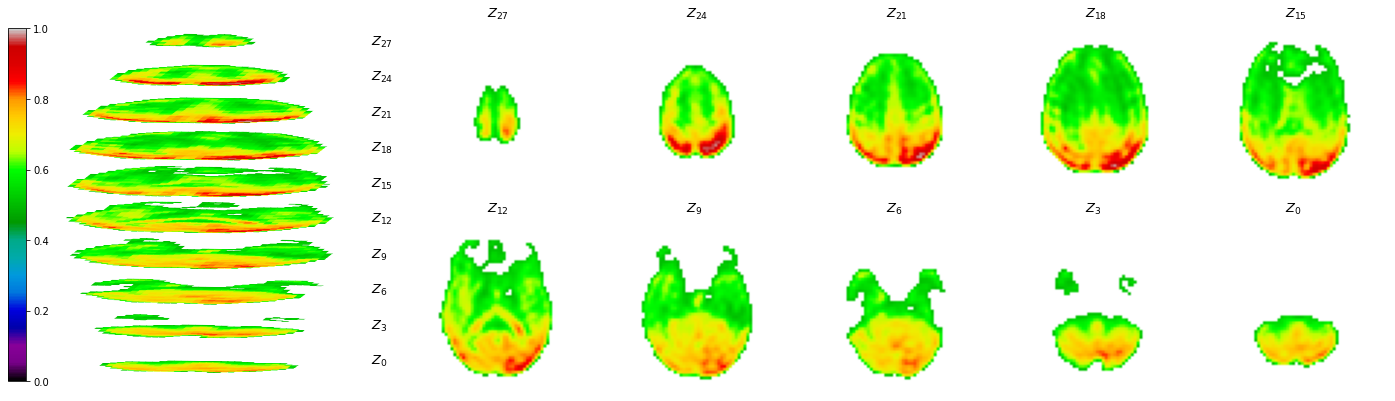

In [7]:
for x, _ in dev_views_set.repeat(1):
    fig = viz_utils.plot_3D_representation_projected_slices(x.numpy()[0,:,:,:,:],
                                                        slice_label=True,
                                                        uncertainty=False,
                                                        threshold=0.50,
                                                       legend_colorbar=r"$\mathbb{E}[R]$",
                                                       save=False,)# save_path=path+"/explainability/fmri_E_R.pdf",
    break

## Explaining prediction

In [ ]:
for x, y in dev_views_set.repeat(1):
    
    print(linearCLF.clf(x).shape)
    break

In [ ]:
explainer = lrp.LRP(linearCLF.clf)
R=lrp.explain(explainer, dev_views_set, verbose=True)

In [ ]:
dev_R_views_set = tf.data.Dataset.from_tensor_slices((R,y_test)).batch(1)

In [ ]:
fig = viz_utils.plot_3D_representation_projected_slices(np.mean(R, axis=0),
                                                        res_img=np.mean(fmri_train,axis=0),
                                                        slice_label=True,
                                                        uncertainty=False,
                                                        cmap=plt.cm.gist_heat,
                                                        threshold=0.2,
                                                       legend_colorbar=r"$\mathbb{E}[R]$",
                                                       save=False,# save_path=path+"/explainability/fmri_E_R.pdf",
                                                       max_min_legend=["Negative","Positive"])

In [ ]:
explainer = lrp.LRP_EEG(linearCLF.view)
attention_scores=lrp.explain(explainer, dev_set, eeg=True, eeg_attention=True, fmri=False, verbose=True)

In [ ]:
viz_utils.plot_attention_eeg(np.mean(attention_scores, axis=0),
                            dataset=dataset,
                            plot_names=True,
                            edge_threshold=np.percentile(attention_scores, 98.5))